In [1]:
pip install google-play-scraper

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google_play_scraper import Sort, reviews
import pandas as pd
import time

app_package = 'com.whatsapp'
all_reviews = []
total_reviews_needed = 10000
batch_size = 100  # Max per request
num_batches = total_reviews_needed // batch_size

# Fetch reviews in chunks
for i in range(num_batches):
    rvs, _ = reviews(
        app_package,
        lang='en',        # English reviews
        country='in',     # India
        sort=Sort.NEWEST,
        count=batch_size,
        continuation_token=None if i == 0 else token
    )
    all_reviews.extend(rvs)
    print(f'Fetched batch {i + 1}/{num_batches} - Total reviews: {len(all_reviews)}')
    token = _  # continuation token for next batch

    time.sleep(1)  # Respectful scraping: avoid hammering the server

# Convert to DataFrame
df = pd.DataFrame(all_reviews)
df = df[['content', 'score']]  # Keep relevant columns

Fetched batch 1/100 - Total reviews: 100
Fetched batch 2/100 - Total reviews: 200
Fetched batch 3/100 - Total reviews: 300
Fetched batch 4/100 - Total reviews: 400
Fetched batch 5/100 - Total reviews: 500
Fetched batch 6/100 - Total reviews: 600
Fetched batch 7/100 - Total reviews: 700
Fetched batch 8/100 - Total reviews: 800
Fetched batch 9/100 - Total reviews: 900
Fetched batch 10/100 - Total reviews: 1000
Fetched batch 11/100 - Total reviews: 1100
Fetched batch 12/100 - Total reviews: 1200
Fetched batch 13/100 - Total reviews: 1300
Fetched batch 14/100 - Total reviews: 1400
Fetched batch 15/100 - Total reviews: 1500
Fetched batch 16/100 - Total reviews: 1600
Fetched batch 17/100 - Total reviews: 1700
Fetched batch 18/100 - Total reviews: 1800
Fetched batch 19/100 - Total reviews: 1900
Fetched batch 20/100 - Total reviews: 2000
Fetched batch 21/100 - Total reviews: 2100
Fetched batch 22/100 - Total reviews: 2200
Fetched batch 23/100 - Total reviews: 2300
Fetched batch 24/100 - Total 

In [3]:
df

,content,score
0,"Dear Whatsapp, I have found no other way to se...",3
1,Nice app,5
2,Unyama sana,5
3,it giving problem... I don't know why it not w...,1
4,WhatsApp band ho gaya he,5
...,...,...
9995,I can't open my WhatsApp,1
9996,WhatsApp is always up to standard. I like the ...,5
9997,वडश,1
9998,excellent,5


In [4]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['cleaned'] = df['content'].apply(lambda x: clean_text(str(x)))
df = df[df['cleaned'].str.strip().astype(bool)]  # Remove empty strings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [5]:
def label_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    return 'positive'

df['sentiment'] = df['score'].apply(label_sentiment)

C:\Users\admin\AppData\Local\Temp\ipykernel_6664\3647701843.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['score'].apply(label_sentiment)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment'])

Model Implementation & Evaluation

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    return 'neutral'

y_pred_vader = X_test.apply(vader_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

In [11]:
!pip install transformers
from transformers import pipeline
transformer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def transformer_sentiment(text):
    try:
        label = transformer(text[:512])[0]['label']
        return 'positive' if label == 'POSITIVE' else 'negative'
    except:
        return 'neutral'

y_pred_bert = X_test.apply(transformer_sentiment)

Device set to use cpu


Evaluation

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate(y_test, y_pred_vader, "VADER")
evaluate(y_test, y_pred_lr, "Logistic Regression")
evaluate(y_test, y_pred_bert, "DistilBERT")


--- VADER ---
              precision    recall  f1-score   support

    negative       0.72      0.47      0.57       701
     neutral       0.06      0.21      0.09       140
    positive       0.87      0.80      0.83      2063

    accuracy                           0.69      2904
   macro avg       0.55      0.49      0.49      2904
weighted avg       0.79      0.69      0.73      2904

Confusion Matrix:
[[ 328  199  174]
 [  27   30   83]
 [ 102  314 1647]]

--- Logistic Regression ---
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67       701
     neutral       0.00      0.00      0.00       140
    positive       0.84      0.93      0.88      2063

    accuracy                           0.81      2904
   macro avg       0.51      0.52      0.52      2904
weighted avg       0.77      0.81      0.79      2904

Confusion Matrix:
[[ 448    0  253]
 [  41    0   99]
 [ 152    0 1911]]

--- DistilBERT ---
              precision    r

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packag

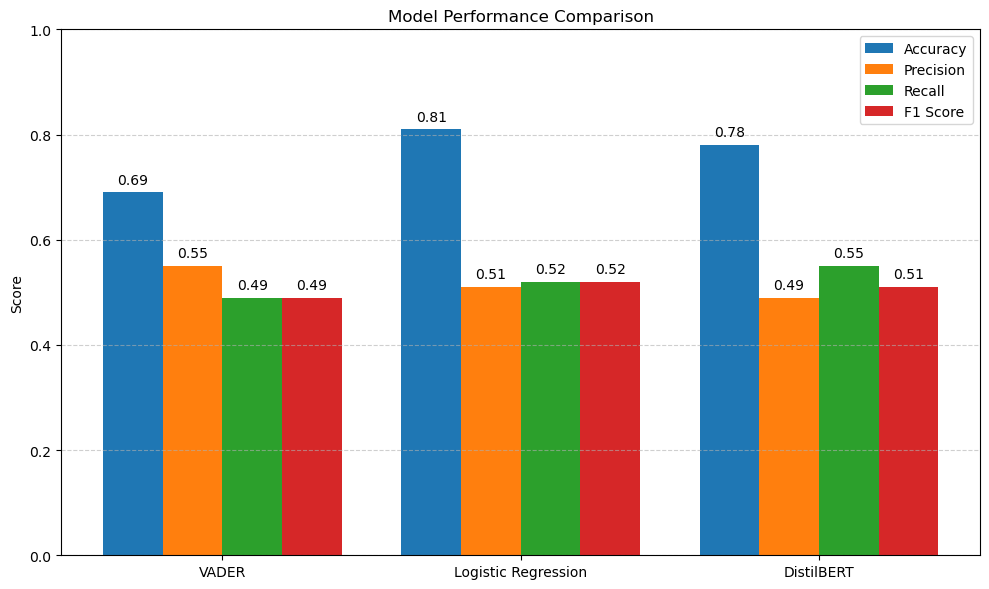

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
models = ['VADER', 'Logistic Regression', 'DistilBERT']
accuracy = [0.69, 0.81, 0.78]
precision = [0.55, 0.51, 0.49]
recall = [0.49, 0.52, 0.55]
f1_score = [0.49, 0.52, 0.51]

# Grouped bar chart setup
x = np.arange(len(models))  # label locations
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='#1f77b4')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='#ff7f0e')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='#2ca02c')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1 Score', color='#d62728')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for r in [rects1, rects2, rects3, rects4]:
    add_labels(r)

plt.tight_layout()
plt.show()


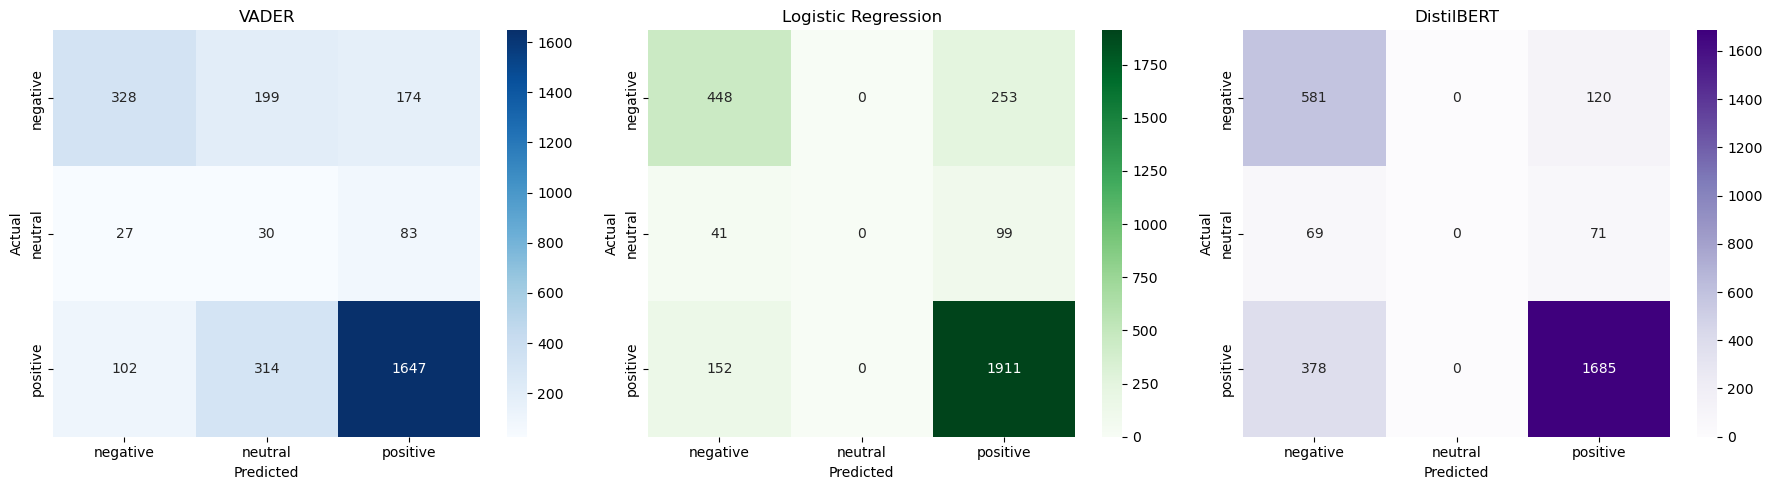

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class labels
labels = ['negative', 'neutral', 'positive']

# Manually entered confusion matrices
cm_vader = np.array([[328, 199, 174],
                     [ 27,  30,  83],
                     [102, 314, 1647]])

cm_lr = np.array([[448,   0, 253],
                  [ 41,   0,  99],
                  [152,   0, 1911]])

cm_bert = np.array([[581,   0, 120],
                    [ 69,   0,  71],
                    [378,   0, 1685]])

# Plot function
def plot_confusion_matrix(cm, title, ax, cmap):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(cm_vader, "VADER", axes[0], "Blues")
plot_confusion_matrix(cm_lr, "Logistic Regression", axes[1], "Greens")
plot_confusion_matrix(cm_bert, "DistilBERT", axes[2], "Purples")

plt.tight_layout()
plt.show()

Testing on sample text

In [17]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

text = "This app is really helpful and easy to use."
score = analyzer.polarity_scores(text)

compound = score['compound']
sentiment = (
    "positive" if compound >= 0.05 else
    "negative" if compound <= -0.05 else
    "neutral"
)

print(f"Predicted Sentiment: {sentiment} (compound score: {compound})")

Predicted Sentiment: positive (compound score: 0.7397)


In [18]:
#DistilBERT
from transformers import pipeline

# Load sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

text = "The app crashes every time I open it."

result = classifier(text)[0]
print(f"Predicted Sentiment: {result['label']} (score: {result['score']:.2f})")

Device set to use cpu


Predicted Sentiment: NEGATIVE (score: 1.00)


In [22]:
import joblib

# Assuming you trained a pipeline named pipe_lr
joblib.dump(pipe_lr, "logistic_model_pipeline.pkl")

['logistic_model_pipeline.pkl']

In [23]:
import joblib
import os

# Path to the saved model
model_path = "logistic_model_pipeline.pkl"

# Check if model file exists
if not os.path.exists(model_path):
    print(f"❌ Error: Model file '{model_path}' not found.")
    print("➡ Ensure the model is trained and saved correctly.")
else:
    # Load the trained pipeline (includes TF-IDF + classifier)
    pipe_lr = joblib.load(model_path)

    # Sample input
    text = ["This app is amazing!"]

    # Predict class probabilities
    probs = pipe_lr.predict_proba(text)
    classes = pipe_lr.classes_

    # Extract top prediction
    predicted_index = probs[0].argmax()
    predicted_label = classes[predicted_index]
    confidence = probs[0][predicted_index]

    print("✅ Prediction Complete")
    print(f"Text: {text[0]}")
    print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.2f})")


✅ Prediction Complete
Text: This app is amazing!
Predicted Sentiment: positive (Confidence: 0.90)
